In [7]:
import datetime as dt
import os

import arviz as az
import numpy as np
import numpyro
import pandas as pd
import xarray as xr
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import (
    aes,
    geom_line,
    facet_grid,
    geom_ribbon,
    ggplot,
    scale_x_datetime,
    theme_bw,
    theme
)
from sklearn.gaussian_process import kernels
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from src.step1_data_loading.data_loading import load_data
from src.step2_preprocessing.preprocessing import XArrayScaler
from src.step3_modeling.ensemble import DefaultEnsemble
from src.step3_modeling.gaussian_process import SklearnGPModel
from src.step3_modeling.metrics import summarize
from src.step3_modeling.modeling import ModelBase
from src.step3_modeling.var_models import VAR, NARX
from src.utils import create_rnbs_snapshot, flatten_array

# device = "cuda"
device = "cpu"

os.environ["JAX_PLATFORM_NAME"] = device

numpyro.set_platform(device)
numpyro.set_host_device_count(4 if device == "cpu" else 1)

In [9]:
def split_data(split_date, lake_data, validation_steps=12, num_years_ahead=1):
    covars = lake_data.sel(type="Basin")[["precip_cfsr", "temp_cfsr"]].to_array().transpose("Date", "lake", ...)
    y_scaler = XArrayScaler()
    y_vals = y_scaler.fit_transform(lake_data["rnbs_hist"])
    lake_snapshot = create_rnbs_snapshot(rnbs_data=y_vals,
                                         covariates=covars,
                                         split_date=split_date,
                                         validation_steps=validation_steps, sequential_validation=True,
                                         num_years_forward=num_years_ahead)
    return lake_snapshot, y_scaler


lake_data = load_data(["rnbs_hist", "precip_cfsr", "temp_cfsr"]).dropna("Date").transpose("Date", "lake", ...)

train_split = dt.datetime(2005, 12, 1)
snapshot, y_scaler = split_data(train_split, lake_data)

scaled_rnbs = XArrayScaler().fit_transform(lake_data["rnbs_hist"])

snapshot.train_y

<xarray.DataArray 'rnbs_hist' (Date: 312, lake: 4)>
array([[-1.18710356, -0.47976789,  0.11801005,  0.73152607],
       [-0.39699687, -0.49125506,  0.58866456, -0.47626258],
       [ 1.14108578,  2.22787517,  1.79230574,  2.43288709],
       ...,
       [ 1.0227839 , -1.21121645, -1.32666825, -1.37218415],
       [-1.30097909, -0.97930135, -0.53905468, -0.32199763],
       [-0.72335854, -0.40277325,  0.357195  ,  0.91545686]])
Coordinates:
  * Date     (Date) datetime64[ns] 1979-01-01 1979-02-01 ... 2004-12-01
  * lake     (lake) object 'sup' 'mic_hur' 'eri' 'ont'

In [13]:
preprocessor = Pipeline(steps=[
    ("scale", XArrayScaler()),
    ("flatten", FunctionTransformer(flatten_array))
])

# use only temp and precip
all_models = {
    "Default": Pipeline(steps=[("preprocessor", preprocessor), ("model", DefaultEnsemble())]),
    "GP_RBF": Pipeline(steps=[("preprocessor", preprocessor), ("model", SklearnGPModel(
        1.0 * kernels.ExpSineSquared(periodicity=12, length_scale=1, length_scale_bounds=(6, 1e5)) + kernels.RBF()))]),
    # "EnsembleNN": Pipeline(steps=[
    #     ("preprocess", preprocessor),
    #     ("model",
    #      SklearnRegressorModel(
    #          sklearn_regressor=MLPRegressor(solver="lbfgs", hidden_layer_sizes=(50, 50,), max_iter=1000,
    #                                         activation="relu"),
    #          n_estimators=250, n_jobs=-1)),
    # ]),
    "VARX": Pipeline(steps=[
        ("preprocess", XArrayScaler()),
        (
            "model",
            VAR(lags={"y": 3, "temp_cfsr": 1, "precip_cfsr": 6}, num_warmup=1500, num_chains=4, num_samples=1000)
        )
    ]),
    "NARX": Pipeline(steps=[
        ("preprocess", XArrayScaler()),
        (
            "model",
            NARX(lags={"y": 3, "temp_cfsr": 1, "precip_cfsr": 6}, num_warmup=1500, num_chains=4, num_samples=1000)
        )
    ]),
}



In [14]:
def fit_model(fit_snapshot, model):
    model.fit(y=fit_snapshot.train_y, X=fit_snapshot.train_x)
    return model


def run_forecasts(start_date, fitted_model: ModelBase, num_years_ahead=10):
    rnbs = scaled_rnbs.rename("true")
    all_dfs = []
    for i in range(12 * num_years_ahead + 1):
        new_split = start_date + relativedelta(months=i)
        new_snapshot, _ = split_data(new_split, lake_data, validation_steps=0, num_years_ahead=1)
        predictions = fitted_model.predict(X=new_snapshot.test_x, y=new_snapshot.test_y, forecast_steps=12)

        months_ahead = xr.DataArray(np.arange(1, 13), dims="Date", coords={"Date": predictions.indexes["Date"]},
                                    name="months_ahead")
        merged_ds = xr.merge([predictions, rnbs, months_ahead]).dropna("Date")
        comparison_df = merged_ds.to_dataframe(["Date", "lake", "value"]).reset_index(
            names=["Date", "lake", "value"]).pivot(index=["Date", "lake", "months_ahead", "true"], columns="value",
                                                   values="forecasts").reset_index()
        all_dfs.append(comparison_df)
    return pd.concat(all_dfs)


snapshot, y_scaler = split_data(train_split, lake_data, num_years_ahead=5, validation_steps=0)
all_model_results = []
fitted_models = {}
for name, model in all_models.items():
    fitted_model = fit_model(snapshot, model)
    fitted_models.update({name: fitted_model})
    predictions = run_forecasts(train_split, model).assign(model=name)
    all_model_results.append(predictions)

results_df = pd.concat(all_model_results)
results_df.head()

/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

value       Date     lake  months_ahead      true     lower      mean  \
0     2006-01-01      eri           1.0  0.969509 -0.828206  0.111313   
1     2006-01-01  mic_hur           1.0  0.720064 -1.470271 -0.487147   
2     2006-01-01      ont           1.0  1.329302 -0.747394 -0.044433   
3     2006-01-01      sup           1.0 -0.737555 -1.693437 -1.083471   
4     2006-02-01      eri           2.0  0.363985 -0.443998  0.409835   

value       std     upper    model  
0      0.831176  1.872672  Default  
1      0.536000  0.266679  Default  
2      0.562895  0.728939  Default  
3      0.374664 -0.437658  Default  
4      0.803959  1.821163  Default

In [15]:
results_df.groupby(["months_ahead", "model"]).apply(summarize, include_groups=False)

rmse     variance      bias  coverage  \
months_ahead model                                                 
1.0          Default   0.539984     0.239286  0.228684  0.921488   
             GP_RBF    1.219682     1.175826  0.558388  0.644628   
             NARX      0.948375     0.750811  0.385492  0.977273   
             VARX      0.586437     0.269372  0.273013  0.962810   
2.0          Default   0.634333     0.290776  0.334069  0.774793   
             GP_RBF    1.175865     1.081969  0.548351  0.793388   
             NARX      0.691538     0.402455  0.275263  0.975207   
             VARX      0.621977     0.315770  0.266617  0.966942   
3.0          Default   0.562905     0.276787  0.200189  0.923554   
             GP_RBF    0.987682     0.969970 -0.074468  0.942149   
             NARX      3.003884     8.741034  0.531307  0.830579   
             VARX      0.645101     0.376964  0.197967  0.966942   
4.0          Default   1.180514     0.741396  0.807600  0.473140   
             GP_RBF    1.016992     0.765610  0.518327  0.942149   
             NARX      1.219219     1.356994  0.359862  0.975207   
             VARX      0.931989     0.578253  0.538843  0.671488   
5.0          Default   0.748672     0.474954  0.292499  0.617769   
             GP_RBF    0.743657     0.494580 -0.241757  0.942149   
             NARX      3.623880    13.122950  0.097764  0.981405   
             VARX      0.692004     0.466978  0.109050  0.973140   
6.0          Default   0.621947     0.323739 -0.251156  0.764463   
             GP_RBF    0.700935     0.476989 -0.119668  0.944215   
             NARX      3.817376    14.418864 -0.391781  0.966942   
             VARX      0.670791     0.329078 -0.347682  0.971074   
7.0          Default   0.620258     0.371381  0.115499  0.917355   
             GP_RBF    0.794461     0.602611 -0.168988  0.944215   
             NARX      2.110364     4.335272 -0.344039  0.985537   
             VARX      0.790913     0.546336 -0.281438  0.971074   
8.0          Default   0.524129     0.256579  0.134653  0.919421   
             GP_RBF    0.821147     0.587024 -0.295394  0.944215   
             NARX      2.765308     7.556960 -0.299944  0.993802   
             VARX      0.621088     0.290995 -0.307823  0.971074   
9.0          Default   0.525321     0.274692  0.035644  0.923554   
             GP_RBF    0.868302     0.724417  0.171848  0.944215   
             NARX      3.925686    15.339776  0.266901  0.991736   
             VARX      0.548552     0.277797 -0.152024  0.969008   
10.0         Default   0.781753     0.525275  0.293024  0.774793   
             GP_RBF    1.112701     1.070075 -0.409914  0.793388   
             NARX      9.441446    88.191689  0.974273  0.997934   
             VARX      0.755518     0.569606  0.034673  0.973140   
11.0         Default   0.586479     0.273570  0.265307  0.929752   
             GP_RBF    1.372338     1.828965 -0.233125  0.791322   
             NARX     11.300632   126.303683  1.183471  0.995868   
             VARX      0.512596     0.259343  0.058414  0.977273   
12.0         Default   0.758118     0.342062  0.482370  0.479339   
             GP_RBF    1.093324     1.070585  0.353231  0.940083   
             NARX     42.928995  1831.136931  3.429531  1.000000   
             VARX      0.757151     0.367811  0.453284  0.977273   

                      interval_len       crps      N  
months_ahead model                                    
1.0          Default      1.839670   0.306953  484.0  
             GP_RBF       2.868764   0.754090  484.0  
             NARX         2.934139   0.418665  484.0  
             VARX         2.177124   0.336939  484.0  
2.0          Default      2.031994   0.364981  484.0  
             GP_RBF       2.984332   0.706694  484.0  
             NARX         2.663081   0.376915  484.0  
             VARX         2.211450   0.352404  484.0  
3.0          Default      1.900052   0.316677  484.0  
             GP_RBF  

/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/mcanea

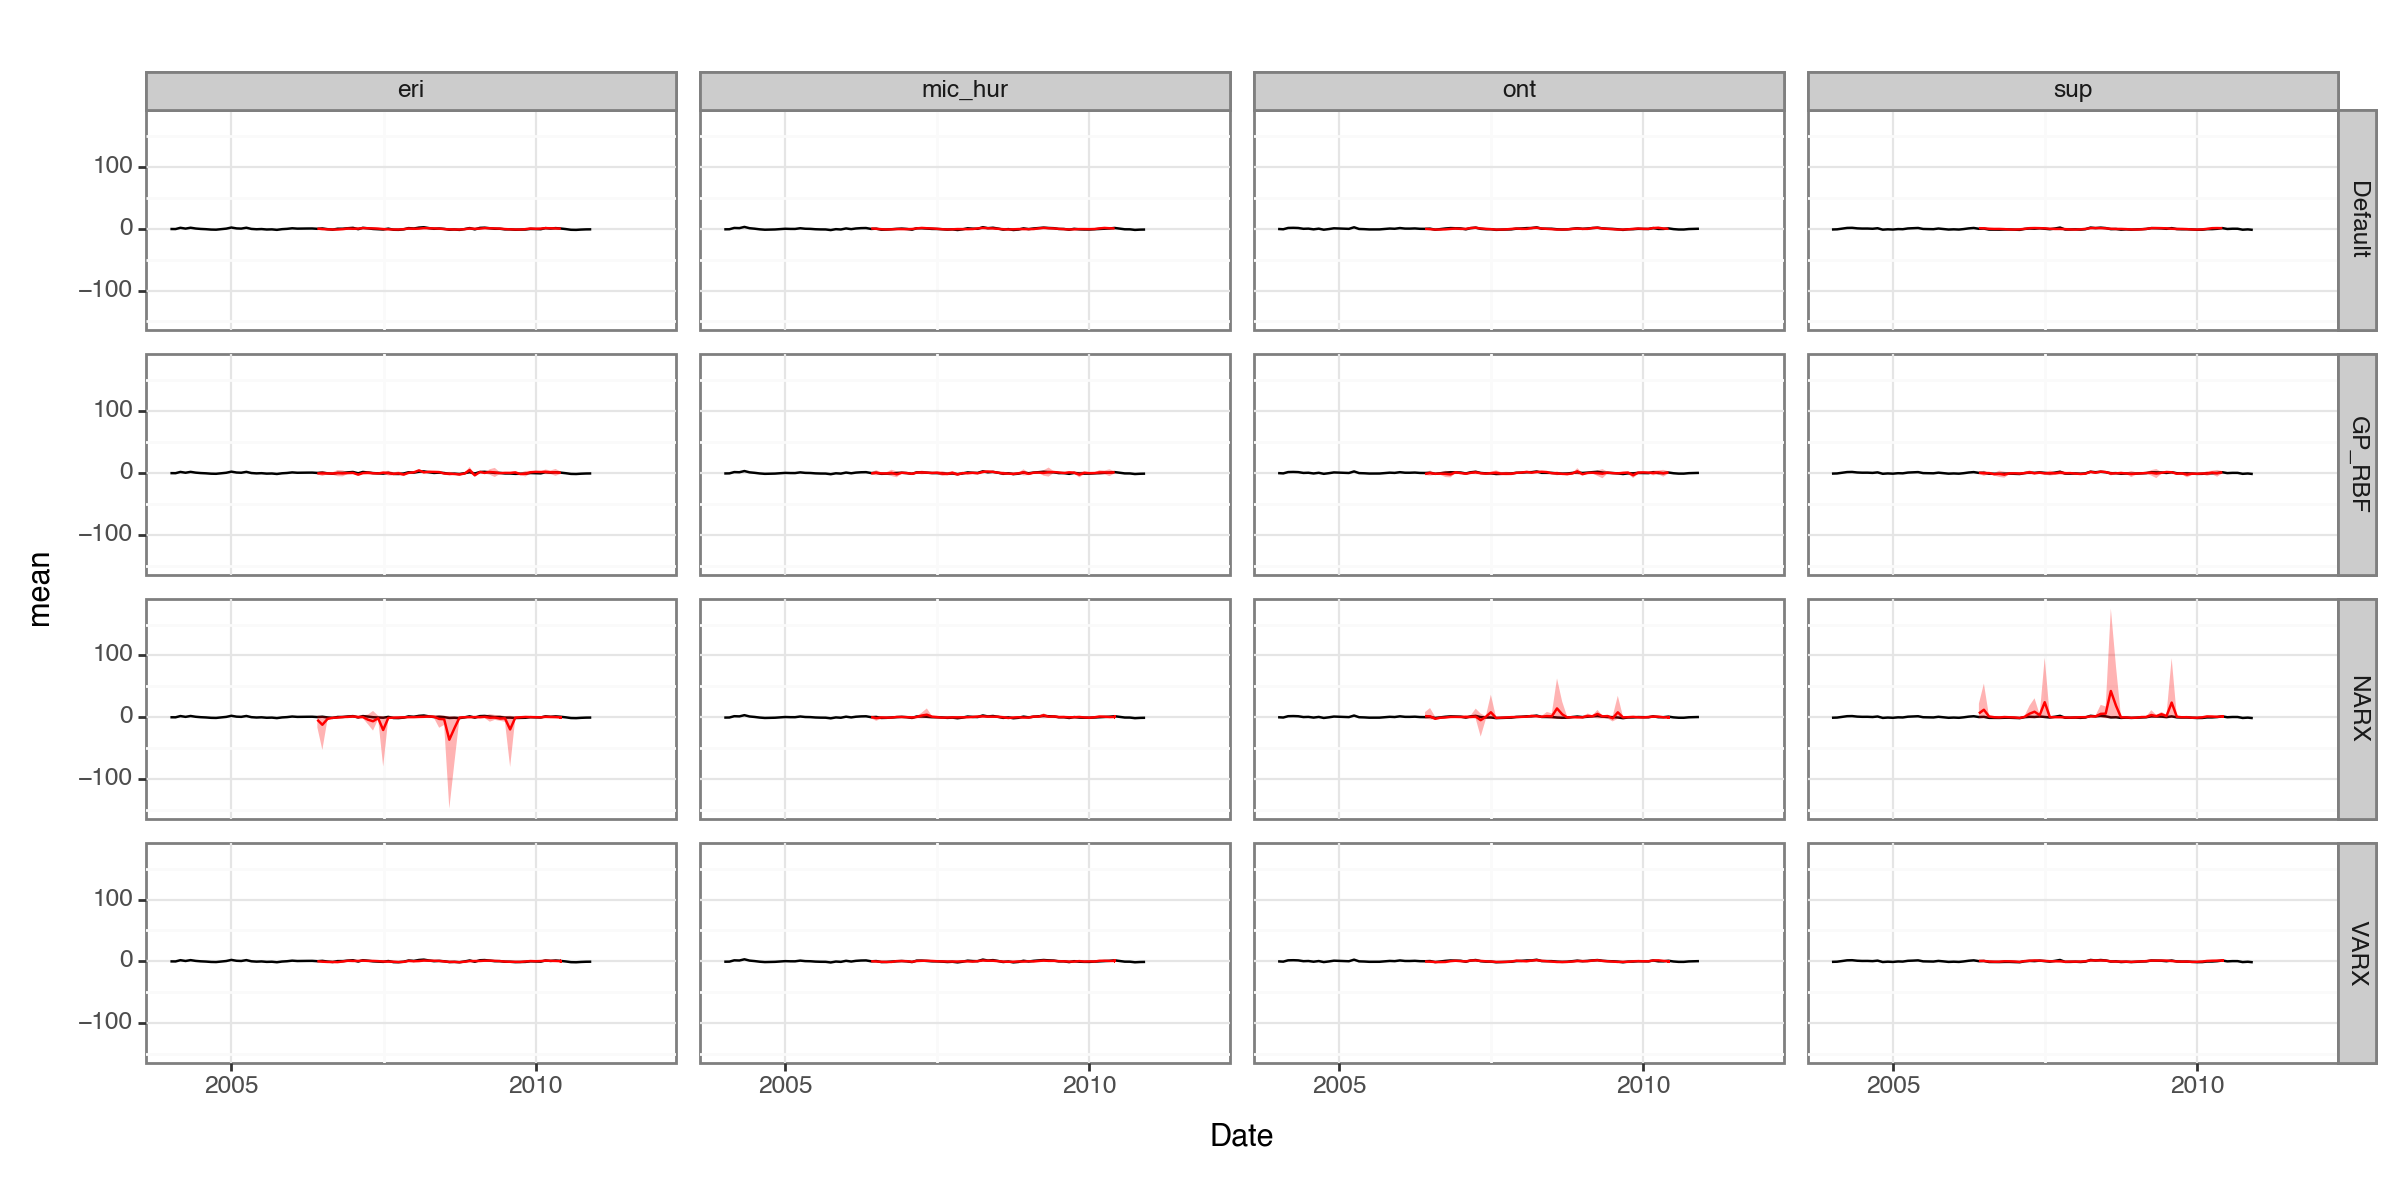

<Figure Size: (1200 x 600)>

In [16]:
og = scaled_rnbs.to_dataframe(name="rnbs").reset_index()
result_subset = results_df[results_df["months_ahead"].isin([6])]

(
        ggplot(data=result_subset, mapping=aes(x="Date", y="mean"))
        + geom_line(data=og, mapping=aes(x="Date", y="rnbs"), inherit_aes=False)
        + geom_line(mapping=aes(x="Date", y="mean"), color="red")
        + facet_grid("model~lake")
        + scale_x_datetime(
    limits=[results_df.Date.min() - relativedelta(years=2), results_df.Date.max() + relativedelta(years=1)],
    labels=date_format(fmt="%Y"), breaks=date_breaks("5 year"))
        + geom_ribbon(
    mapping=aes(x="Date", ymin="lower", ymax="upper"), fill="red", alpha=0.3,
)
        + theme_bw()
        + theme(figure_size=(12, 6))
)


/Users/mcanearm/miniconda3/envs/noaa_mvp/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values


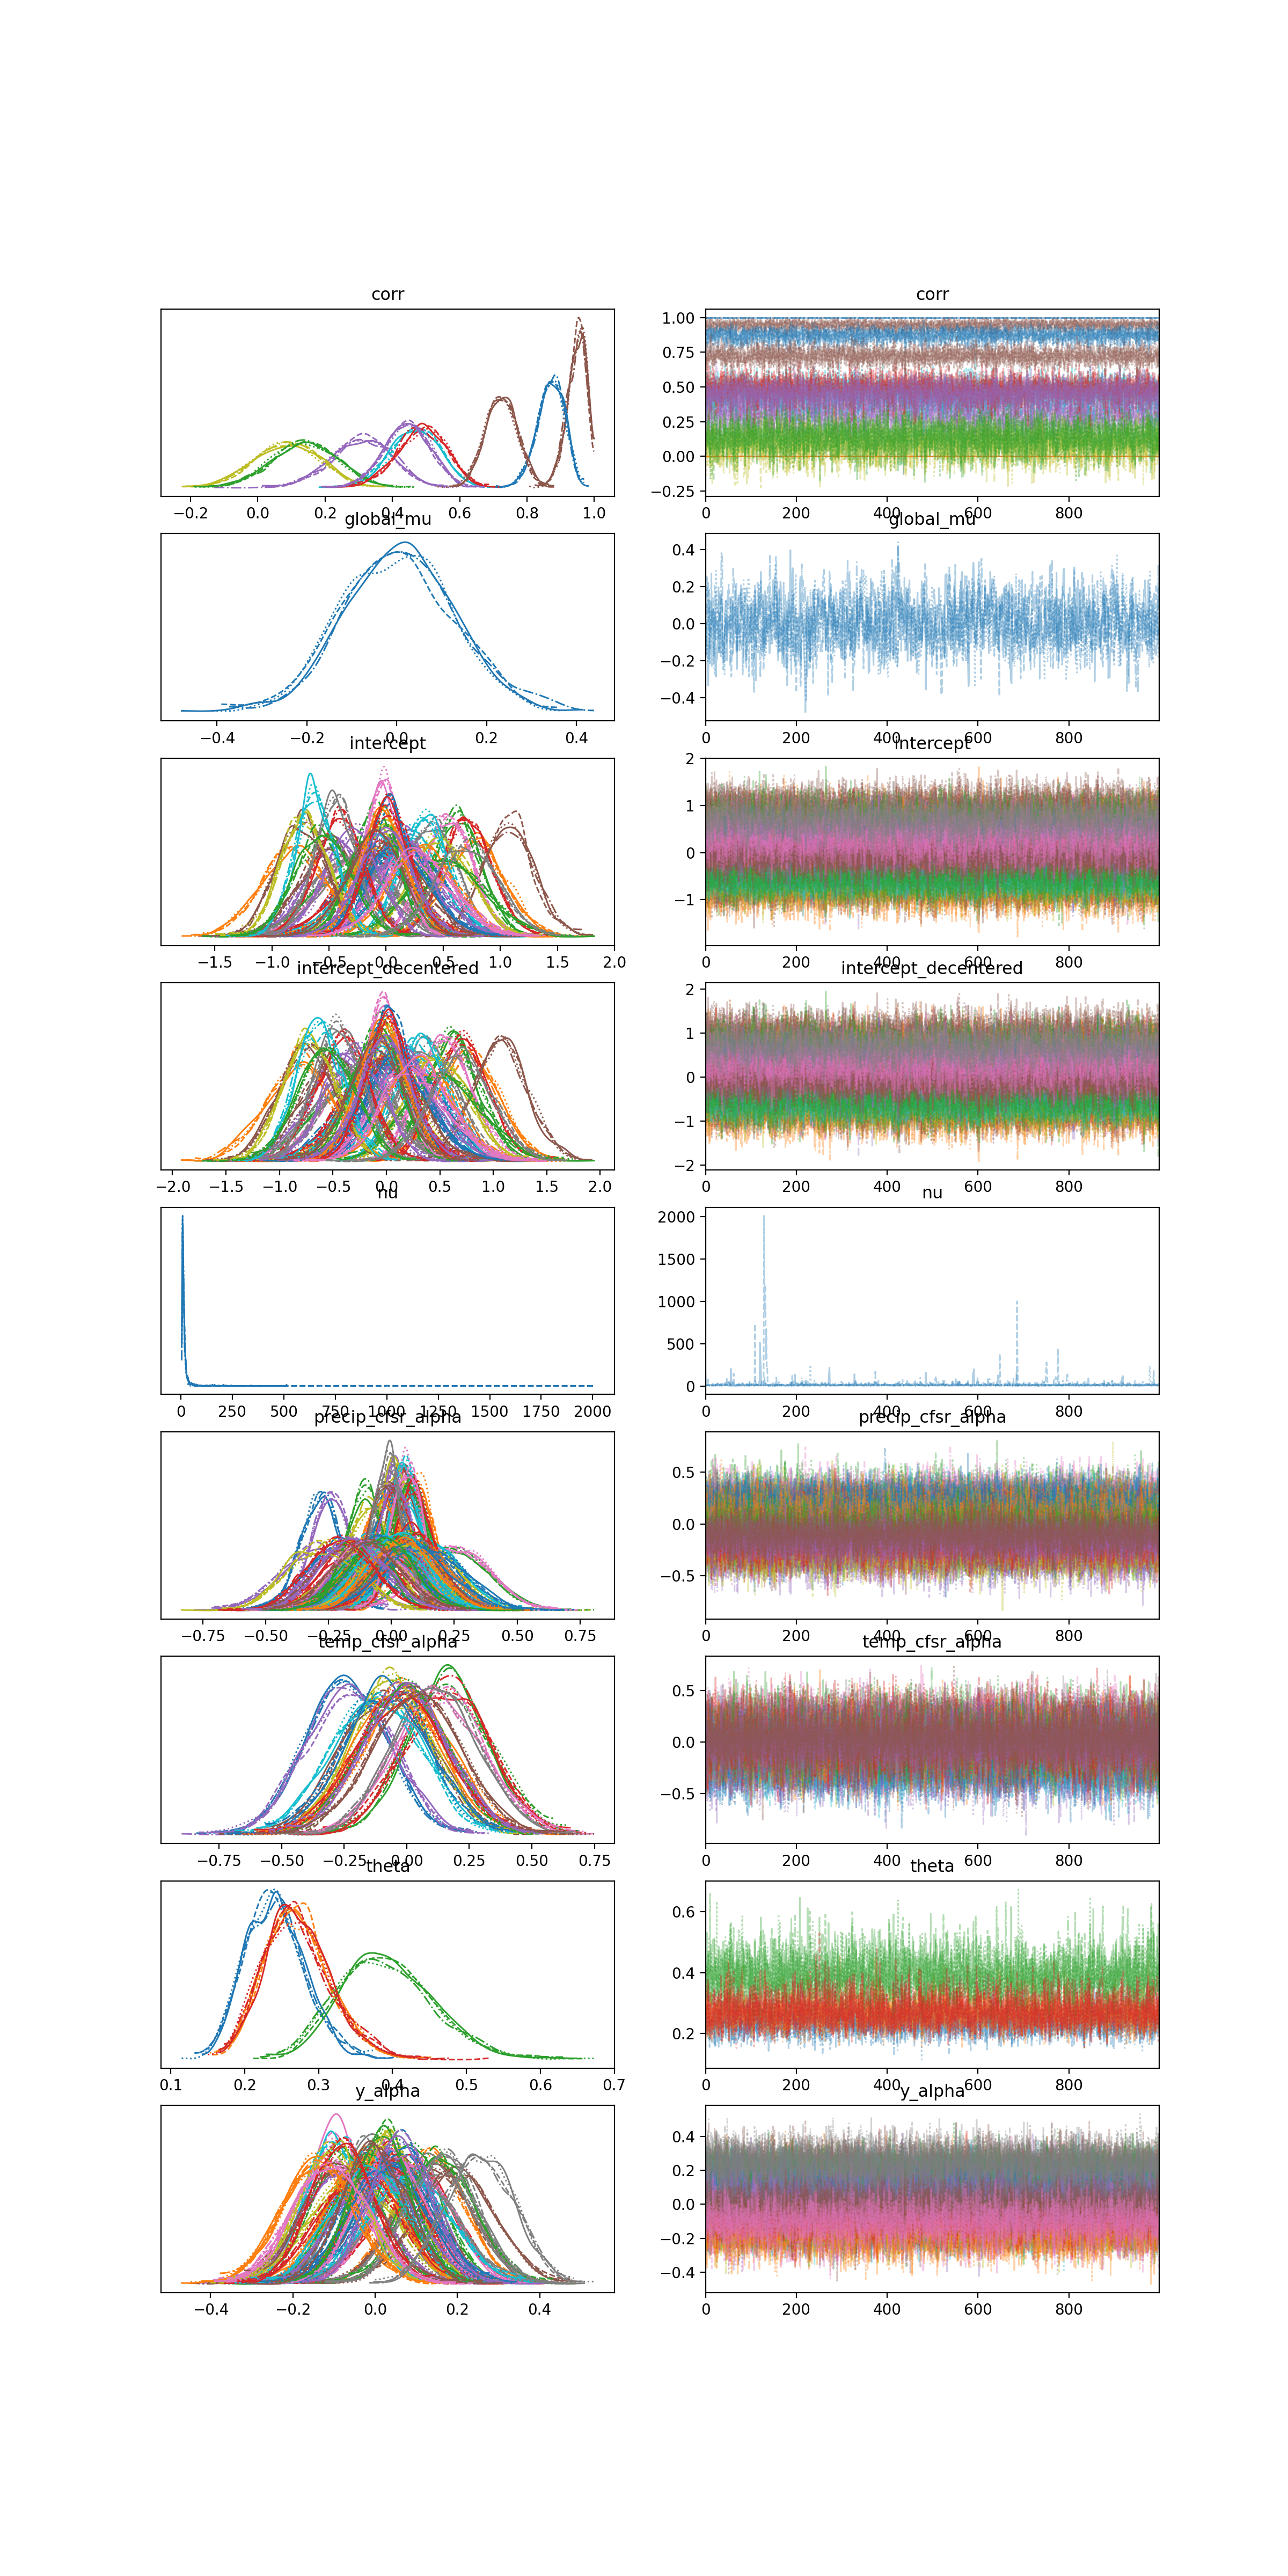

In [17]:
model = fitted_models["VARX"].steps[-1][1]
az.plot_trace(model.trace, figsize=(12, 24))

plt.show()


In [35]:
summarized = az.summary(model.trace, filter_vars="regex", var_names=["alpha"])

summarized[~((summarized["hdi_3%"] <= 0) & (summarized["hdi_97%"] >= 0))]

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
evap_alpha[sup, sup, 1]           -0.250  0.120  -0.466   -0.016      0.002   
evap_alpha[mic_hur, eri, 1]       -0.340  0.169  -0.679   -0.051      0.003   
evap_alpha[eri, eri, 1]           -0.503  0.190  -0.880   -0.165      0.004   
precip_alpha[sup, sup, 1]          0.556  0.045   0.471    0.640      0.001   
precip_alpha[mic_hur, mic_hur, 1]  0.531  0.052   0.432    0.627      0.001   
precip_alpha[eri, eri, 1]          0.518  0.058   0.411    0.631      0.001   
precip_alpha[ont, ont, 1]          0.504  0.057   0.396    0.611      0.001   
y_alpha[sup, sup, 2]               0.118  0.052   0.023    0.215      0.001   

                                   mcse_sd  ess_bulk  ess_tail  r_hat  
evap_alpha[sup, sup, 1]              0.002    2707.0    2469.0    1.0  
evap_alpha[mic_hur, eri, 1]          0.002    2403.0    2634.0    1.0  
evap_alpha[eri, eri, 1]              0.003    2373.0    2930.0    1.0  
precip_alpha[sup, sup, 1]            0.001    3607.0    2839.0    1.0  
precip_alpha[mic_hur, mic_hur, 1]    0.001    3054.0    2836.0    1.0  
precip_alpha[eri, eri, 1]            0.001    3667.0    3076.0    1.0  
precip_alpha[ont, ont, 1]            0.001    3161.0    2977.0    1.0  
y_alpha[sup, sup, 2]                 0.001    3611.0    3301.0    1.0